In [144]:
import os
import logging

logging.basicConfig(level=logging.INFO)

from autogl.backend import DependentBackend

if DependentBackend.is_dgl():
    from autogl.module.model.dgl import BaseAutoModel
    from dgl.data import CoraGraphDataset
elif DependentBackend.is_pyg():
    from torch_geometric.datasets import Planetoid
    from autogl.module.model.pyg import BaseAutoModel
from autogl.datasets import build_dataset_from_name
import torch
from torch import nn
import torch.nn.functional as F
#from autogl.module.nas.algorithm.agnn_rl import AGNNRL
from autogl.module.nas.backend import bk_feat, bk_label
from autogl.module.nas.algorithm import Darts, RL, GraphNasRL, Enas, RandomSearch,Spos,AGNNRL
from autogl.module.nas.estimator import BaseEstimator
from autogl.module.train.evaluation import Acc
import numpy as np
from autogl.solver.utils import set_seed
from autogl.module.nas.space import BaseSpace
import typing as _typ
from architecture import light_read, gnn_list, gnn_list_proteins, Arch
import pandas as pd
import argparse
import os
import os.path as osp

In [145]:
# Define the search space in NAS-bench-graph
class StrModule(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.name = lambd

    def forward(self, *args, **kwargs):
        return self.name

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, self.name)

class BenchSpace(BaseSpace):
    def __init__(
        self,
        hidden_dim: _typ.Optional[int] = 64,
        layer_number: _typ.Optional[int] = 2,
        dropout: _typ.Optional[float] = 0.9,
        input_dim: _typ.Optional[int] = None,
        output_dim: _typ.Optional[int] = None,
        ops_type = 0
    ):
        super().__init__()
        self.layer_number = layer_number
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.ops_type=ops_type

    def instantiate(
        self,
        hidden_dim: _typ.Optional[int] = None,
        layer_number: _typ.Optional[int] = None,
        dropout: _typ.Optional[float] = None,
        input_dim: _typ.Optional[int] = None,
        output_dim: _typ.Optional[int] = None,
        ops_type=None
    ):
        super().instantiate()
        self.dropout = dropout or self.dropout
        self.hidden_dim = hidden_dim or self.hidden_dim
        self.layer_number = layer_number or self.layer_number
        self.input_dim = input_dim or self.input_dim
        self.output_dim = output_dim or self.output_dim
        self.ops_type = ops_type or self.ops_type
        self.ops = [gnn_list,gnn_list_proteins][self.ops_type]
        for layer in range(4):
            setattr(self,f"in{layer}",self.setInputChoice(layer,n_candidates=layer+1,n_chosen=1,return_mask=False,key=f"in{layer}"))
            setattr(self,f"op{layer}",self.setLayerChoice(layer,list(map(lambda x:StrModule(x),self.ops)),key=f"op{layer}"))
        self.dummy=nn.Linear(1,1)

    def forward(self, bench):
        lks = [getattr(self, "in" + str(i)).selected for i in range(4)]
        ops = [getattr(self, "op" + str(i)).name for i in range(4)]
        arch = Arch(lks, ops)
        h = arch.valid_hash()
        if h == "88888" or h==88888:
            return 0
        return bench[h]['perf']

    def parse_model(self, selection, device) -> BaseAutoModel:
        return self.wrap().fix(selection)

# Define a new estimator which directly get performance from NAS-bench-graph instead of training the model
class BenchEstimator(BaseEstimator):
    def __init__(self, data_name, loss_f="nll_loss", evaluation=[Acc()]):
        super().__init__(loss_f, evaluation)
        self.evaluation = evaluation
        self.bench=light_read(data_name)
    def infer(self, model: BaseSpace, dataset, mask="train"):
        perf=model(self.bench)
        return [perf],0


In [146]:
# Run NAS with NAS-bench-graph
def run(data_name='cora',algo='graphnas',num_epochs=50,ctrl_steps_aggregate=20,log_dir='./logs/tmp'):
    print("Testing backend: {}".format("dgl" if DependentBackend.is_dgl() else "pyg"))
    if DependentBackend.is_dgl():
        from autogl.datasets.utils.conversion._to_dgl_dataset import to_dgl_dataset as convert_dataset
    else:
        from autogl.datasets.utils.conversion._to_pyg_dataset import to_pyg_dataset as convert_dataset

    di=2
    do=2
    dataset=None

    ops_type=data_name=='proteins'

    space = BenchSpace().cuda()
    space.instantiate(input_dim=di, output_dim=do,ops_type=ops_type)
    esti = BenchEstimator(data_name)
    if algo=='graphnas':
        algo = GraphNasRL(num_epochs=num_epochs,ctrl_steps_aggregate=ctrl_steps_aggregate)
    elif algo=='agnn':
        algo = AGNNRL(guide_type=1,num_epochs=num_epochs,ctrl_steps_aggregate=ctrl_steps_aggregate)
    elif algo=='rl':
        algo = RL(num_epochs=num_epochs,ctrl_steps_aggregate=ctrl_steps_aggregate)
    elif algo=='random':
        algo = RandomSearch(num_epochs=num_epochs)
    elif algo=='darts':
        algo = Darts(num_epochs=num_epochs)
    elif algo=='enas':
        algo = Enas(num_epochs=num_epochs,ctrl_steps_aggregate=ctrl_steps_aggregate)
    elif algo=='spos':
        algo = Spos(n_warmup=num_epochs//20,cycles=num_epochs)
    else:
        assert False,f'Not implemented algo {algo}'
    model = algo.search(space, dataset, esti)
    result=esti.infer(model._model,None)[0][0]
    
    os.makedirs(log_dir,exist_ok=True)
    with open(osp.join(log_dir,f'log.txt'),'w') as f:
        f.write(str(result))

    import json
    archs=algo.allhist
    json.dump(archs,open(osp.join(log_dir,f'archs.json'),'w'))
 
    best_archs = algo.best_archs
    print(best_archs)

    arch_strs=[str(x[1]) for x in archs]
    print(f'number of archs: {len(arch_strs)} ; number of unique archs : {len(set(arch_strs))}')   


    scores=[x[0] for x in archs] # accs
    idxs=np.argsort(scores) # increasing order
    with open(osp.join(log_dir,f'idx.txt'),'w') as f:
        f.write(str(idxs))
    return result, best_archs

In [147]:
dname = 'cora'
algo = 'graphnas'
log_dir = './logs'

In [148]:
log_dir= os.path.join(log_dir,f'{dname,algo}')

num_epochs=100
ctrl_steps_aggregate=10
result, best_archs=run(dname,algo,num_epochs,ctrl_steps_aggregate,log_dir)

Testing backend: dgl
Model: BenchSpace(
  (in0): PathSamplingInputChoice(n_candidates=1, chosen=None)
  (op0): PathSamplingLayerChoice(op_names=['0', '1', '2', '3', '4', '5', '6', '7', '8'], chosen=None)
  (in1): PathSamplingInputChoice(n_candidates=2, chosen=None)
  (op1): PathSamplingLayerChoice(op_names=['0', '1', '2', '3', '4', '5', '6', '7', '8'], chosen=None)
  (in2): PathSamplingInputChoice(n_candidates=3, chosen=None)
  (op2): PathSamplingLayerChoice(op_names=['0', '1', '2', '3', '4', '5', '6', '7', '8'], chosen=None)
  (in3): PathSamplingInputChoice(n_candidates=4, chosen=None)
  (op3): PathSamplingLayerChoice(op_names=['0', '1', '2', '3', '4', '5', '6', '7', '8'], chosen=None)
  (dummy): Linear(in_features=1, out_features=1, bias=True)
)


100%|██████████████| 10/10 [00:00<00:00, 28.87it/s, acc=0.785, max_acc=0.815]
INFO:RL_NAS:epoch:0, mean rewards:0.7801
100%|██████████████| 10/10 [00:00<00:00, 50.20it/s, acc=0.797, max_acc=0.808]
INFO:RL_NAS:epoch:1, mean rewards:0.7939
100%|██████████████| 10/10 [00:00<00:00, 43.06it/s, acc=0.731, max_acc=0.804]
INFO:RL_NAS:epoch:2, mean rewards:0.7863
100%|██████████████| 10/10 [00:00<00:00, 29.64it/s, acc=0.798, max_acc=0.798]
INFO:RL_NAS:epoch:3, mean rewards:0.7821666666666667
100%|██████████████| 10/10 [00:00<00:00, 29.33it/s, acc=0.765, max_acc=0.807]
INFO:RL_NAS:epoch:4, mean rewards:0.7910333333333333
100%|██████████████| 10/10 [00:00<00:00, 23.18it/s, acc=0.746, max_acc=0.803]
INFO:RL_NAS:epoch:5, mean rewards:0.7762
 90%|█████████████▌ | 9/10 [00:00<00:00, 19.96it/s, acc=0.778, max_acc=0.795]


100%|██████████████| 10/10 [00:00<00:00, 21.30it/s, acc=0.799, max_acc=0.799]
INFO:RL_NAS:epoch:6, mean rewards:0.7831
100%|██████████████| 10/10 [00:00<00:00, 31.17it/s, acc=0.812, max_acc=0.812]
INFO:RL_NAS:epoch:7, mean rewards:0.7937333333333333
100%|█████████████████| 10/10 [00:00<00:00, 19.51it/s, acc=0.73, max_acc=0.8]
INFO:RL_NAS:epoch:8, mean rewards:0.7633000000000001
100%|██████████████| 10/10 [00:00<00:00, 20.72it/s, acc=0.794, max_acc=0.811]
INFO:RL_NAS:epoch:9, mean rewards:0.7843666666666668
100%|██████████████| 10/10 [00:00<00:00, 30.59it/s, acc=0.796, max_acc=0.813]
INFO:RL_NAS:epoch:10, mean rewards:0.7918666666666667
100%|██████████████| 10/10 [00:00<00:00, 31.56it/s, acc=0.799, max_acc=0.804]
INFO:RL_NAS:epoch:11, mean rewards:0.7928666666666666
100%|██████████████| 10/10 [00:00<00:00, 29.00it/s, acc=0.807, max_acc=0.809]
INFO:RL_NAS:epoch:12, mean rewards:0.7946666666666669
 30%|████▌          | 3/10 [00:00<00:00, 25.61it/s, acc=0.789, max_acc=0.805]


100%|██████████████| 10/10 [00:00<00:00, 33.41it/s, acc=0.794, max_acc=0.805]
INFO:RL_NAS:epoch:13, mean rewards:0.7640666666666667
100%|██████████████| 10/10 [00:00<00:00, 35.93it/s, acc=0.738, max_acc=0.824]
INFO:RL_NAS:epoch:14, mean rewards:0.7640666666666667
100%|██████████████| 10/10 [00:00<00:00, 39.41it/s, acc=0.807, max_acc=0.807]
INFO:RL_NAS:epoch:15, mean rewards:0.7654666666666667
100%|██████████████| 10/10 [00:00<00:00, 40.04it/s, acc=0.808, max_acc=0.808]
INFO:RL_NAS:epoch:16, mean rewards:0.7912333333333335
100%|██████████████| 10/10 [00:00<00:00, 34.93it/s, acc=0.751, max_acc=0.808]
INFO:RL_NAS:epoch:17, mean rewards:0.7790333333333334
100%|██████████████| 10/10 [00:00<00:00, 31.46it/s, acc=0.797, max_acc=0.802]
INFO:RL_NAS:epoch:18, mean rewards:0.7796333333333334
100%|██████████████| 10/10 [00:00<00:00, 35.81it/s, acc=0.751, max_acc=0.797]
INFO:RL_NAS:epoch:19, mean rewards:0.7766666666666667
 40%|██████         | 4/10 [00:00<00:00, 38.43it/s, acc=0.791, max_acc=0.812

100%|██████████████| 10/10 [00:00<00:00, 31.17it/s, acc=0.795, max_acc=0.812]
INFO:RL_NAS:epoch:20, mean rewards:0.7941333333333332
100%|██████████████| 10/10 [00:00<00:00, 34.50it/s, acc=0.784, max_acc=0.818]
INFO:RL_NAS:epoch:21, mean rewards:0.7701666666666667
100%|██████████████| 10/10 [00:00<00:00, 37.13it/s, acc=0.764, max_acc=0.799]
INFO:RL_NAS:epoch:22, mean rewards:0.7505333333333335
100%|██████████████| 10/10 [00:00<00:00, 38.20it/s, acc=0.793, max_acc=0.806]
INFO:RL_NAS:epoch:23, mean rewards:0.7294333333333334
100%|███████████████| 10/10 [00:00<00:00, 36.19it/s, acc=0.798, max_acc=0.81]
INFO:RL_NAS:epoch:24, mean rewards:0.7911666666666668
100%|██████████████| 10/10 [00:00<00:00, 45.40it/s, acc=0.799, max_acc=0.801]
INFO:RL_NAS:epoch:25, mean rewards:0.7852333333333333
100%|██████████████| 10/10 [00:00<00:00, 39.02it/s, acc=0.791, max_acc=0.803]
INFO:RL_NAS:epoch:26, mean rewards:0.7653000000000001
  0%|                        | 0/10 [00:00<?, ?it/s, acc=0.768, max_acc=0.81

100%|███████████████| 10/10 [00:00<00:00, 36.26it/s, acc=0.801, max_acc=0.81]
INFO:RL_NAS:epoch:27, mean rewards:0.783
100%|██████████████| 10/10 [00:00<00:00, 37.41it/s, acc=0.791, max_acc=0.807]
INFO:RL_NAS:epoch:28, mean rewards:0.7851333333333333
100%|██████████████| 10/10 [00:00<00:00, 40.86it/s, acc=0.699, max_acc=0.807]
INFO:RL_NAS:epoch:29, mean rewards:0.7787000000000001
100%|██████████████| 10/10 [00:00<00:00, 37.21it/s, acc=0.804, max_acc=0.807]
INFO:RL_NAS:epoch:30, mean rewards:0.7948000000000001
100%|███████████████| 10/10 [00:00<00:00, 40.12it/s, acc=0.69, max_acc=0.808]
INFO:RL_NAS:epoch:31, mean rewards:0.7608333333333335
100%|██████████████| 10/10 [00:00<00:00, 26.43it/s, acc=0.789, max_acc=0.808]
INFO:RL_NAS:epoch:32, mean rewards:0.7522000000000001
100%|████████████████| 10/10 [00:00<00:00, 31.61it/s, acc=0.8, max_acc=0.807]
INFO:RL_NAS:epoch:33, mean rewards:0.7908
  0%|                       | 0/10 [00:00<?, ?it/s, acc=0.733, max_acc=0.733]


100%|██████████████| 10/10 [00:00<00:00, 38.64it/s, acc=0.793, max_acc=0.811]
INFO:RL_NAS:epoch:34, mean rewards:0.7589666666666667
100%|████████████████| 10/10 [00:00<00:00, 29.95it/s, acc=0.8, max_acc=0.802]
INFO:RL_NAS:epoch:35, mean rewards:0.7576333333333335
100%|██████████████| 10/10 [00:00<00:00, 33.58it/s, acc=0.802, max_acc=0.805]
INFO:RL_NAS:epoch:36, mean rewards:0.7878333333333334
100%|██████████████| 10/10 [00:00<00:00, 40.78it/s, acc=0.791, max_acc=0.814]
INFO:RL_NAS:epoch:37, mean rewards:0.7803333333333333
100%|██████████████| 10/10 [00:00<00:00, 29.55it/s, acc=0.705, max_acc=0.804]
INFO:RL_NAS:epoch:38, mean rewards:0.7766666666666667
100%|██████████████| 10/10 [00:00<00:00, 45.82it/s, acc=0.792, max_acc=0.808]
INFO:RL_NAS:epoch:39, mean rewards:0.7947
100%|██████████████| 10/10 [00:00<00:00, 32.49it/s, acc=0.784, max_acc=0.799]
INFO:RL_NAS:epoch:40, mean rewards:0.7837
 41%|█████▋        | 41/100 [00:12<00:17,  3.39it/s, reward_controller=0.784]


100%|██████████████| 10/10 [00:00<00:00, 43.53it/s, acc=0.759, max_acc=0.803]
INFO:RL_NAS:epoch:41, mean rewards:0.7857666666666667
100%|██████████████| 10/10 [00:00<00:00, 35.68it/s, acc=0.773, max_acc=0.802]
INFO:RL_NAS:epoch:42, mean rewards:0.7776666666666667
100%|██████████████| 10/10 [00:00<00:00, 44.79it/s, acc=0.789, max_acc=0.805]
INFO:RL_NAS:epoch:43, mean rewards:0.7937666666666667
100%|██████████████| 10/10 [00:00<00:00, 44.70it/s, acc=0.787, max_acc=0.803]
INFO:RL_NAS:epoch:44, mean rewards:0.7931666666666668
100%|██████████████| 10/10 [00:00<00:00, 43.43it/s, acc=0.807, max_acc=0.814]
INFO:RL_NAS:epoch:45, mean rewards:0.7890666666666666
100%|██████████████| 10/10 [00:00<00:00, 28.83it/s, acc=0.801, max_acc=0.809]
INFO:RL_NAS:epoch:46, mean rewards:0.7939666666666666
100%|██████████████| 10/10 [00:00<00:00, 33.19it/s, acc=0.744, max_acc=0.805]
INFO:RL_NAS:epoch:47, mean rewards:0.7783666666666667


100%|████████████████| 10/10 [00:00<00:00, 33.35it/s, acc=0.8, max_acc=0.806]
INFO:RL_NAS:epoch:48, mean rewards:0.7834666666666668
100%|██████████████| 10/10 [00:00<00:00, 29.55it/s, acc=0.797, max_acc=0.797]
INFO:RL_NAS:epoch:49, mean rewards:0.7884333333333334
100%|███████████████| 10/10 [00:00<00:00, 19.43it/s, acc=0.801, max_acc=0.81]
INFO:RL_NAS:epoch:50, mean rewards:0.7927000000000001
100%|███████████████| 10/10 [00:00<00:00, 25.95it/s, acc=0.77, max_acc=0.814]
INFO:RL_NAS:epoch:51, mean rewards:0.7916000000000001
100%|██████████████| 10/10 [00:00<00:00, 31.86it/s, acc=0.769, max_acc=0.813]
INFO:RL_NAS:epoch:52, mean rewards:0.7901333333333334
100%|██████████████| 10/10 [00:00<00:00, 31.02it/s, acc=0.757, max_acc=0.805]
INFO:RL_NAS:epoch:53, mean rewards:0.7797
 60%|█████████      | 6/10 [00:00<00:00, 19.60it/s, acc=0.782, max_acc=0.796]


100%|██████████████| 10/10 [00:00<00:00, 23.75it/s, acc=0.798, max_acc=0.798]
INFO:RL_NAS:epoch:54, mean rewards:0.7869333333333334
100%|██████████████| 10/10 [00:00<00:00, 36.93it/s, acc=0.795, max_acc=0.817]
INFO:RL_NAS:epoch:55, mean rewards:0.7867999999999999
100%|██████████████| 10/10 [00:00<00:00, 37.21it/s, acc=0.796, max_acc=0.808]
INFO:RL_NAS:epoch:56, mean rewards:0.7685
100%|██████████████| 10/10 [00:00<00:00, 45.20it/s, acc=0.796, max_acc=0.809]
INFO:RL_NAS:epoch:57, mean rewards:0.7255999999999999
100%|██████████████| 10/10 [00:00<00:00, 51.49it/s, acc=0.779, max_acc=0.806]
INFO:RL_NAS:epoch:58, mean rewards:0.7782666666666666
100%|████████████████| 10/10 [00:00<00:00, 52.86it/s, acc=0.702, max_acc=0.8]
INFO:RL_NAS:epoch:59, mean rewards:0.7642
100%|██████████████| 10/10 [00:00<00:00, 48.26it/s, acc=0.765, max_acc=0.801]
INFO:RL_NAS:epoch:60, mean rewards:0.7856
 60%|█████████      | 6/10 [00:00<00:00, 55.25it/s, acc=0.787, max_acc=0.802]


100%|██████████████| 10/10 [00:00<00:00, 51.37it/s, acc=0.785, max_acc=0.802]
INFO:RL_NAS:epoch:61, mean rewards:0.7778000000000002
100%|██████████████| 10/10 [00:00<00:00, 53.72it/s, acc=0.779, max_acc=0.807]
INFO:RL_NAS:epoch:62, mean rewards:0.7870000000000001
100%|██████████████| 10/10 [00:00<00:00, 51.24it/s, acc=0.793, max_acc=0.805]
INFO:RL_NAS:epoch:63, mean rewards:0.7837333333333334
100%|██████████████| 10/10 [00:00<00:00, 49.21it/s, acc=0.801, max_acc=0.802]
INFO:RL_NAS:epoch:64, mean rewards:0.7573333333333333
100%|██████████████| 10/10 [00:00<00:00, 38.13it/s, acc=0.777, max_acc=0.784]
INFO:RL_NAS:epoch:65, mean rewards:0.7327
100%|██████████████| 10/10 [00:00<00:00, 41.89it/s, acc=0.792, max_acc=0.799]
INFO:RL_NAS:epoch:66, mean rewards:0.7798333333333334
100%|██████████████| 10/10 [00:00<00:00, 33.81it/s, acc=0.787, max_acc=0.809]
INFO:RL_NAS:epoch:67, mean rewards:0.7891666666666667
100%|██████████████| 10/10 [00:00<00:00, 26.64it/s, acc=0.799, max_acc=0.803]
INFO:RL_NA

100%|██████████████| 10/10 [00:00<00:00, 42.33it/s, acc=0.788, max_acc=0.798]
INFO:RL_NAS:epoch:69, mean rewards:0.7801
100%|██████████████| 10/10 [00:00<00:00, 45.31it/s, acc=0.795, max_acc=0.806]
INFO:RL_NAS:epoch:70, mean rewards:0.7940333333333334
100%|██████████████| 10/10 [00:00<00:00, 46.25it/s, acc=0.764, max_acc=0.814]
INFO:RL_NAS:epoch:71, mean rewards:0.7845333333333333
100%|██████████████| 10/10 [00:00<00:00, 53.29it/s, acc=0.734, max_acc=0.811]
INFO:RL_NAS:epoch:72, mean rewards:0.7712333333333333
100%|██████████████| 10/10 [00:00<00:00, 60.93it/s, acc=0.781, max_acc=0.805]
INFO:RL_NAS:epoch:73, mean rewards:0.7817999999999999
100%|██████████████| 10/10 [00:00<00:00, 59.82it/s, acc=0.791, max_acc=0.811]
INFO:RL_NAS:epoch:74, mean rewards:0.7823333333333334
100%|██████████████| 10/10 [00:00<00:00, 65.93it/s, acc=0.799, max_acc=0.805]
INFO:RL_NAS:epoch:75, mean rewards:0.7755333333333334
  0%|                                                 | 0/10 [00:00<?, ?it/s]


100%|██████████████| 10/10 [00:00<00:00, 53.00it/s, acc=0.803, max_acc=0.805]
INFO:RL_NAS:epoch:76, mean rewards:0.7188333333333333
100%|██████████████| 10/10 [00:00<00:00, 54.75it/s, acc=0.762, max_acc=0.809]
INFO:RL_NAS:epoch:77, mean rewards:0.7871333333333335
100%|██████████████| 10/10 [00:00<00:00, 51.24it/s, acc=0.807, max_acc=0.807]
INFO:RL_NAS:epoch:78, mean rewards:0.7798333333333335
100%|██████████████| 10/10 [00:00<00:00, 58.94it/s, acc=0.798, max_acc=0.809]
INFO:RL_NAS:epoch:79, mean rewards:0.8018666666666668
100%|██████████████| 10/10 [00:00<00:00, 55.81it/s, acc=0.773, max_acc=0.811]
INFO:RL_NAS:epoch:80, mean rewards:0.7898666666666666
100%|███████████████| 10/10 [00:00<00:00, 61.87it/s, acc=0.744, max_acc=0.81]
INFO:RL_NAS:epoch:81, mean rewards:0.7904
100%|██████████████| 10/10 [00:00<00:00, 61.68it/s, acc=0.799, max_acc=0.804]
INFO:RL_NAS:epoch:82, mean rewards:0.7943333333333332
  0%|                        | 0/10 [00:00<?, ?it/s, acc=0.783, max_acc=0.82]


100%|███████████████| 10/10 [00:00<00:00, 55.97it/s, acc=0.772, max_acc=0.82]
INFO:RL_NAS:epoch:83, mean rewards:0.7431333333333333
100%|██████████████| 10/10 [00:01<00:00,  9.93it/s, acc=0.803, max_acc=0.808]
INFO:RL_NAS:epoch:84, mean rewards:0.7809666666666667
100%|██████████████| 10/10 [00:00<00:00, 22.00it/s, acc=0.779, max_acc=0.803]
INFO:RL_NAS:epoch:85, mean rewards:0.7738333333333334
100%|██████████████| 10/10 [00:00<00:00, 33.12it/s, acc=0.797, max_acc=0.808]
INFO:RL_NAS:epoch:86, mean rewards:0.7925000000000001
100%|██████████████| 10/10 [00:00<00:00, 31.16it/s, acc=0.795, max_acc=0.815]
INFO:RL_NAS:epoch:87, mean rewards:0.7995333333333333
100%|██████████████| 10/10 [00:01<00:00,  6.09it/s, acc=0.795, max_acc=0.815]
INFO:RL_NAS:epoch:88, mean rewards:0.797
 90%|█████████████▌ | 9/10 [00:03<00:00,  2.18it/s, acc=0.806, max_acc=0.806]


100%|██████████████| 10/10 [00:03<00:00,  3.05it/s, acc=0.806, max_acc=0.806]
INFO:RL_NAS:epoch:89, mean rewards:0.7825666666666666
100%|██████████████| 10/10 [00:02<00:00,  4.92it/s, acc=0.808, max_acc=0.808]
INFO:RL_NAS:epoch:90, mean rewards:0.7839
100%|██████████████| 10/10 [00:05<00:00,  1.82it/s, acc=0.797, max_acc=0.808]
INFO:RL_NAS:epoch:91, mean rewards:0.7905000000000001
100%|██████████████| 10/10 [00:02<00:00,  3.78it/s, acc=0.783, max_acc=0.807]
INFO:RL_NAS:epoch:92, mean rewards:0.7963666666666668
100%|██████████████| 10/10 [00:02<00:00,  3.51it/s, acc=0.799, max_acc=0.802]
INFO:RL_NAS:epoch:93, mean rewards:0.7888666666666667
 60%|█████████      | 6/10 [00:00<00:00, 11.81it/s, acc=0.755, max_acc=0.814]


100%|██████████████| 10/10 [00:00<00:00, 11.02it/s, acc=0.774, max_acc=0.814]
INFO:RL_NAS:epoch:94, mean rewards:0.7888333333333334
100%|████████████████| 10/10 [00:01<00:00,  6.81it/s, acc=0.798, max_acc=0.8]
INFO:RL_NAS:epoch:95, mean rewards:0.7798999999999999
100%|██████████████| 10/10 [00:01<00:00,  7.79it/s, acc=0.795, max_acc=0.815]
INFO:RL_NAS:epoch:96, mean rewards:0.7976666666666667
100%|██████████████| 10/10 [00:01<00:00,  7.42it/s, acc=0.785, max_acc=0.822]
INFO:RL_NAS:epoch:97, mean rewards:0.7893333333333332
100%|██████████████| 10/10 [00:02<00:00,  4.35it/s, acc=0.785, max_acc=0.802]
INFO:RL_NAS:epoch:98, mean rewards:0.7789666666666666
100%|██████████████| 10/10 [00:00<00:00, 11.67it/s, acc=0.753, max_acc=0.804]
INFO:RL_NAS:epoch:99, mean rewards:0.7887666666666667
100%|█████████████| 100/100 [00:52<00:00,  1.89it/s, reward_controller=0.789]


100%|███████████████████████████████████████| 20/20 [00:00<00:00, 160.47it/s]
INFO:RL_NAS:selection {'lks': [0, 0, 0, 2], 'ops': ['fc', 'gat', 'fc', 'gin']} 
 acc 0.8243 +- 0.0000
100%|███████████████████████████████████████| 20/20 [00:00<00:00, 176.79it/s]
INFO:RL_NAS:selection {'lks': [0, 0, 0, 1], 'ops': ['gat', 'cheb', 'skip', 'gat']} 
 acc 0.8223 +- 0.0000
100%|███████████████████████████████████████| 20/20 [00:00<00:00, 173.01it/s]
INFO:RL_NAS:selection {'lks': [0, 1, 0, 0], 'ops': ['gat', 'gat', 'sage', 'gat']} 
 acc 0.8197 +- 0.0000
100%|███████████████████████████████████████| 20/20 [00:00<00:00, 183.32it/s]
INFO:RL_NAS:selection {'lks': [0, 0, 0, 3], 'ops': ['graph', 'gcn', 'gin', 'gat']} 
 acc 0.8183 +- 0.0000
100%|███████████████████████████████████████| 20/20 [00:00<00:00, 176.06it/s]
INFO:RL_NAS:selection {'lks': [0, 0, 2, 2], 'ops': ['cheb', 'gin', 'gat', 'arma']} 
 acc 0.8167 +- 0.0000


[[0.8243333333333333, {'lks': [0, 0, 0, 2], 'ops': ['fc', 'gat', 'fc', 'gin']}], [0.8223333333333332, {'lks': [0, 0, 0, 1], 'ops': ['gat', 'cheb', 'skip', 'gat']}], [0.8196666666666668, {'lks': [0, 1, 0, 0], 'ops': ['gat', 'gat', 'sage', 'gat']}], [0.8183333333333334, {'lks': [0, 0, 0, 3], 'ops': ['graph', 'gcn', 'gin', 'gat']}], [0.8166666666666667, {'lks': [0, 0, 2, 2], 'ops': ['cheb', 'gin', 'gat', 'arma']}]]
number of archs: 1000 ; number of unique archs : 998


In [149]:
best_archs

[[0.8243333333333333,
  {'lks': [0, 0, 0, 2], 'ops': ['fc', 'gat', 'fc', 'gin']}],
 [0.8223333333333332,
  {'lks': [0, 0, 0, 1], 'ops': ['gat', 'cheb', 'skip', 'gat']}],
 [0.8196666666666668,
  {'lks': [0, 1, 0, 0], 'ops': ['gat', 'gat', 'sage', 'gat']}],
 [0.8183333333333334,
  {'lks': [0, 0, 0, 3], 'ops': ['graph', 'gcn', 'gin', 'gat']}],
 [0.8166666666666667,
  {'lks': [0, 0, 2, 2], 'ops': ['cheb', 'gin', 'gat', 'arma']}]]

In [150]:
def regularize(lks,ops):
    lk = lks[:]
    ops = ops[:]
    if lk == [0,0,0,2]:
        lk = [0,0,0,1]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,0,3]:
        lk = [0,0,0,1]
        ops = [ops[2], ops[0], ops[1], ops[3]]
    elif lk == [0,0,1,0]:
        lk = [0,0,0,1]
        ops = [ops[0], ops[1], ops[3], ops[2]]
    elif lk == [0,0,2,0]:
        lk = [0,0,0,1]
        ops = [ops[1], ops[0], ops[3], ops[2]]
    elif lk == [0,0,2,1]:
        lk = [0,0,1,2]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,2,2]:
        lk = [0,0,1,1]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,2,3]:
        lk = [0,0,1,3]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,1,0,0]:
        lk = [0,0,0,1]
        ops = [ops[0], ops[2], ops[3], ops[1]]
    elif lk == [0,1,0,1]:
        lk = [0,0,1,1]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,0,2]:
        lk = [0,0,1,3]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,0,3]:
        lk = [0,0,1,2]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,1,0]:
        lk = [0,0,1,1]
        ops = [ops[0], ops[3], ops[1], ops[2]]
    elif lk == [0,1,1,3]:
        lk = [0,1,1,2]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,2,0]:
        lk = [0,0,1,3]
        ops = [ops[0], ops[3], ops[1], ops[2]]
    elif lk == [0,1,2,1]:
        lk = [0,1,1,2]
        ops = [ops[0], ops[1], ops[3], ops[2]]
    return {'lks':lk,'ops':ops}

In [151]:
for i, (score, arch) in enumerate(best_archs):
    best_archs[i][1] = regularize(arch['lks'],arch['ops'])

In [152]:
best_archs

[[0.8243333333333333,
  {'lks': [0, 0, 0, 1], 'ops': ['gat', 'fc', 'fc', 'gin']}],
 [0.8223333333333332,
  {'lks': [0, 0, 0, 1], 'ops': ['gat', 'cheb', 'skip', 'gat']}],
 [0.8196666666666668,
  {'lks': [0, 0, 0, 1], 'ops': ['gat', 'sage', 'gat', 'gat']}],
 [0.8183333333333334,
  {'lks': [0, 0, 0, 1], 'ops': ['gin', 'graph', 'gcn', 'gat']}],
 [0.8166666666666667,
  {'lks': [0, 0, 1, 1], 'ops': ['gin', 'cheb', 'gat', 'arma']}]]

In [153]:
from graphviz import Digraph
def gen_graph(arch):
    lks, ops = arch['lks'], arch['ops']
    g = Digraph()

    g.node('0', "Input")
    g.node('1', ops[0])
    g.node('2', ops[1])
    g.node('3', ops[2])
    g.node('4', ops[3])
    g.node('5', "Output")
    
    g.edges([str(lks[i]) + str(i+1) for i in range(4)])
    if lks[-1] == 0:
        g.edges(['15','25','35','45'])
    elif lks[-1] == 1:
        g.edges(['45','35','25'])
    elif lks[-1] == 2:
        g.edges(['45','35'])
    elif lks[-1] == 3:
        if lks[-2] == 2:
            g.edges(['45'])
        else:
            g.edges(['45','25'])
            
    g.graph_attr['rankdir'] = 'LR' 
    return g

In [154]:
link_list = [
[0,0,0,0], # 0000->output
[0,0,0,1], # 100->output 
[0,0,1,1], # 110->output
[0,0,1,2], # 12->output
[0,0,1,3], # 13->outpu
[0,1,1,1], # 111->output
[0,1,1,2], # 12->output
[0,1,2,2], # 22->output
[0,1,2,3] # 3->output
]

In [155]:
for i, (score, arch) in enumerate(best_archs):
    graph = gen_graph(arch)
    graph.render('./Arch_Graph/best_arch'+str(i),view=True, format='jpg')
 

In [156]:
from PIL import Image

Acc: 0.8243333333333333


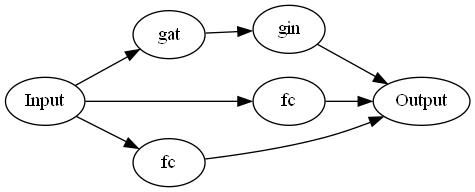

In [157]:
print("Acc:",best_archs[0][0])
display(Image.open("./Arch_Graph/best_arch0.jpg"))

Acc: 0.8223333333333332


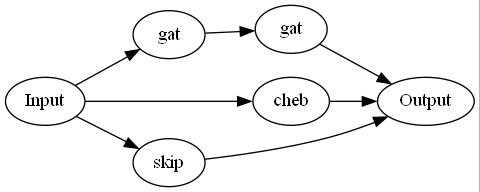

In [158]:
print("Acc:",best_archs[1][0])
display(Image.open("./Arch_Graph/best_arch1.jpg"))

Acc: 0.8196666666666668


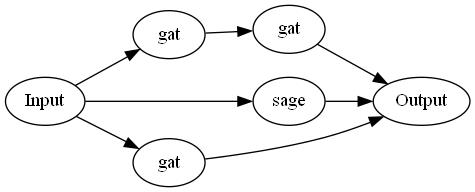

In [159]:
print("Acc:",best_archs[2][0])
display(Image.open("./Arch_Graph/best_arch2.jpg"))

Acc: 0.8183333333333334


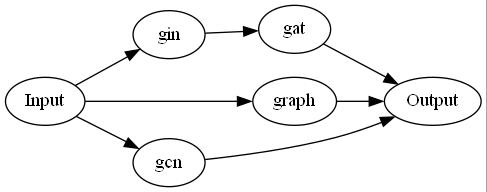

In [160]:
print("Acc:",best_archs[3][0])
display(Image.open("./Arch_Graph/best_arch3.jpg"))

Acc: 0.8166666666666667


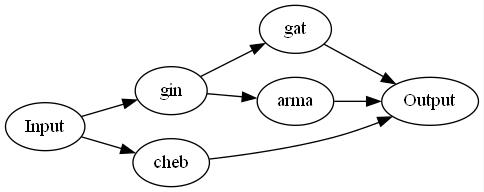

In [161]:
print("Acc:",best_archs[4][0])
display(Image.open("./Arch_Graph/best_arch4.jpg"))